# Finite State Machine
* To download notebook to this tutorial, see [here](https://github.com/defipy-devs/defipy-docs/blob/main/docs/tutorials/fsm.ipynb) 

<img src="../img/state_machine.png" alt="Alt Text" width="400"/>

Useful for when we want to factor in the supply of mintable/burnable token in a simulated DEX environment; typically, there are four states to consider in these types of situations, as per figure above, which are as follows:

* Mint
* Hold
* In-use (LP)
* Burn

### ðŸ“˜ Notable Classes

---

* **Class**: ðŸ“˜ ``defipy.analytics.simulate.TokenSupplyState`` 
    * **Purpose**: Manage mintable/burnable token supply states.
    * **Methods**:
        * ``next_state(minted = None)``
        * ``get_current_state(state_name = None)``
        * ``inspect_states(tail = True, num_states = 5)``
        * ``check_states()``

In [4]:
from defipy import *
import numpy as np
import datetime
import matplotlib.pyplot as plt

### Simulate GBM process

In [3]:
# Instantiation Parameters
n_steps = 500     # Number of steps 
start_price = 10 # Initial price SYS/USD
mu = 0.1; sigma = 0.5
n_paths = 1      # Number of simulationed paths
seconds_year = 31536000

# Brownian Model 
bm = BrownianModel(start_price)
p_arr = bm.gen_gbms(mu, sigma, n_steps-1, n_paths).flatten()

dt = datetime.timedelta(seconds=seconds_year/n_steps)
dates = [datetime.datetime.strptime("2024-09-01", '%Y-%m-%d') + k*dt for k in range(n_steps)]

### Setup UniV2 Pool

In [3]:
user_nm = 'user0'
finite_tkn_amt = 1000
market_tkn_amt = p_arr[0]*finite_tkn_amt

ftkn_nm = 'FTKN'
mtkn_nm = 'MTKN'

lp_state = TokenSupplyState(stochastic = True)
TKN_amt = TokenDeltaModel(100)

finite_tkn = ERC20(ftkn_nm, "0x111")
market_tkn = ERC20(mtkn_nm, "0x09")
exchg_data = UniswapExchangeData(tkn0 = finite_tkn, tkn1 = market_tkn, symbol="LP", address="0x011")

factory = UniswapFactory("pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, finite_tkn_amt, market_tkn_amt)

lp.summary()

Exchange FTKN-MTKN (LP)
Reserves: FTKN = 1000.0, MTKN = 10000.0
Liquidity: 3162.2776601683795 



### Simulation: Random Swapping + Token Supply

In [4]:
arb = CorrectReserves(lp, x0 = p_arr[0])
mint_finite_tkn_deposit = TKN_amt.delta()
lp_state.next_state(mint_finite_tkn_deposit) 

pFTKN_MTKN_arr = []; 

for k in range(n_steps):

    # *****************************
    # ***** Token Supply ******
    # *****************************
    mint_finite_tkn_deposit = TKN_amt.delta()
    lp_state.next_state(mint_finite_tkn_deposit) 
    lp_diff_amt = lp_state.get_current_state('dLP')  

    if(lp_diff_amt > 0):
        AddLiquidity().apply(lp, finite_tkn, user_nm, lp_diff_amt)        
    elif(lp_diff_amt < 0):
        RemoveLiquidity().apply(lp, finite_tkn, user_nm, abs(lp_diff_amt))  
    
    # *****************************
    # ***** Random Swapping ******
    # *****************************
    Swap().apply(lp, finite_tkn, user_nm, TKN_amt.delta())
    Swap().apply(lp, market_tkn, user_nm, p_arr[k]*TKN_amt.delta())
    
    # *****************************
    # ***** Rebalance ******
    # *****************************
    arb.apply(p_arr[k])

    # *****************************
    # ******* Data Capture ********
    # *****************************
    pFTKN_MTKN_arr.append(LPQuote().get_price(lp, finite_tkn))

lp.summary()

Exchange FTKN-MTKN (LP)
Reserves: FTKN = 7270.9112748747275, MTKN = 48291.68168177554
Liquidity: 18412.486449709115 



In [5]:
lp_state.check_states()
lp_state.inspect_states(tail = True, num_states = 5)

Amount of tokens retained across states: PASS


Mint         Held           LP         Burn       dHeld         dLP  \
496   6.197709  1461.746027  4997.481565  4126.305875 -178.265581  266.384755   
497   1.911922  1422.617935  5015.953375  4153.159866  -39.128092   18.471810   
498   7.842685  1584.937663  4839.653810  4169.051625  162.319728 -176.299565   
499  56.223322  1267.204562  5164.140312  4170.140908 -317.733101  324.486502   
500   3.968017  1328.861096  5148.020451  4180.827558   61.656533  -16.119861   

         dBurn  
496  11.696139  
497  26.853992  
498  15.891759  
499   1.089284  
500  10.686649

### Plot Results

In [6]:
dfDistrLP = lp_state.get_state_df()

mint = dfDistrLP.Mint.values
held = dfDistrLP.Held.values
lpool = dfDistrLP.LP.values
burned = dfDistrLP.Burn.values

fig, (mint_ax, hold_ax, lp_ax, burn_ax) = plt.subplots(nrows=4, sharex=True, sharey=False, figsize=(12, 10))
fig.suptitle(f'Token Supply Breakdown {ftkn_nm}', fontsize=20)
mint_ax.plot(dates, mint[1:], color = 'g', label = 'mint') 
mint_ax.set_xlabel("Time unit", fontsize=12)
mint_ax.set_ylabel("Minted Tokens", fontsize=14)  

hold_ax.plot(dates, held[1:], color = 'blue', label = 'hold') 
hold_ax.set_xlabel("Time unit", fontsize=12)
hold_ax.set_ylabel("Held Tokens", fontsize=14)    

lp_ax.plot(dates, lpool[1:], color = 'r', label = 'lp') 
lp_ax.set_xlabel("Time unit", fontsize=12)
lp_ax.set_ylabel("LP Tokens", fontsize=14)

burn_ax.plot(dates, burned[1:], color = 'black', label = 'burned') 
burn_ax.set_xlabel("Time unit", fontsize=12)
burn_ax.set_ylabel("Burned Tokens", fontsize=14)
plt.tight_layout()

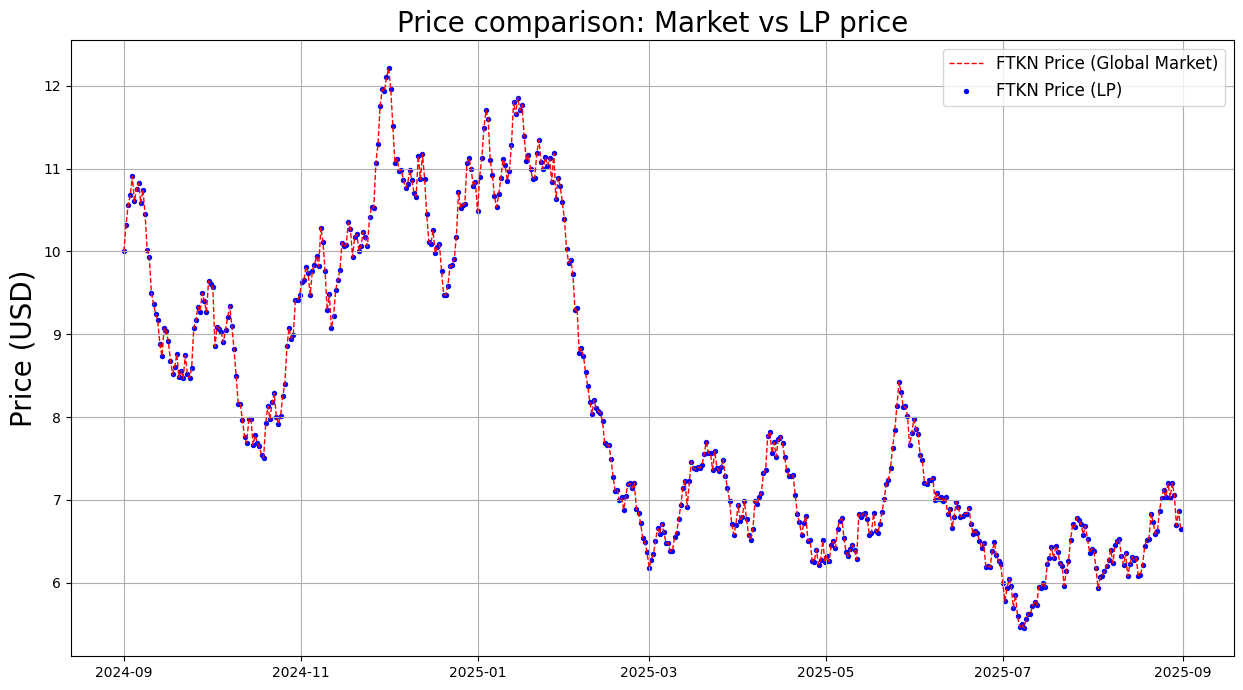

In [7]:
fig, (TKN_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(15, 8))

TKN_ax.plot(dates, p_arr, color = 'r',linestyle = 'dashed', linewidth=1, label=f'{ftkn_nm} Price (Global Market)')
TKN_ax.scatter(dates, pFTKN_MTKN_arr, s=10, marker='o', color = 'b',linestyle = '-', linewidth=0.7, label=f'{ftkn_nm} Price (LP)')

TKN_ax.set_title('Price comparison: Market vs LP price', fontsize=20)
TKN_ax.set_ylabel('Price (USD)', size=20)
TKN_ax.legend(fontsize=12)
TKN_ax.grid()